Install Required Packages

In [4]:
## Importing required packages
import numpy as np
import nose
import matplotlib
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.feature as feat
import sklearn.preprocessing as pre
import matplotlib.patches as mpatches

from skimage.color import label2rgb, rgb2grey
from skimage.segmentation import clear_border
from os.path import join as pjoin
from scipy import ndimage as ndi
from skimage.filters.rank import mean_bilateral
from skimage.restoration import denoise_bilateral
from igor import binarywave
from skimage.morphology import disk, closing, square, opening
from skimage.filters.rank import median
from skimage.io import imshow as show
from skimage.measure import label, regionprops
from skimage.util import invert

In [5]:
#advanced watershed attempt
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
import cv2

In [6]:
## Setting user variables for importing dataset

folder_path = 'D:/doped_10_14/filtered/'


## Importing the image data from .ibw and assigning to list dat
d = {}
dat = []
for root, dirs, files in os.walk(folder_path):
    for i, name in enumerate(files):
        d = binarywave.load(root + '/' + name)
        dat.append((d['wave']['wData']))

In [7]:
## Extracting data into observables and normalizing

height = [dat[i][:,:,0] for i in range(len(dat))]
for k in range(len(height)):
    height[k] = pre.StandardScaler().fit_transform(height[k])

amp1 = [dat[i][:,:,1] for i in range(len(dat))]
for k in range(len(height)):
    amp1[k] = pre.StandardScaler().fit_transform(amp1[k])

amp2 = [dat[i][:,:,2] for i in range(len(dat))]
for k in range(len(height)):
    amp2[k] = pre.StandardScaler().fit_transform(amp2[k])

phase1 = [dat[i][:,:,3] for i in range(len(dat))]
for k in range(len(height)):
    phase1[k] = pre.StandardScaler().fit_transform(phase1[k])

phase2 = [dat[i][:,:,4] for i in range(len(dat))]
for k in range(len(height)):
    phase2[k] = pre.StandardScaler().fit_transform(phase2[k])


In [8]:
## Registering data via translation from the regist data set

regist = height[0]

translation =[feat.register_translation((regist),(height[i]))[0] for i in range(len(height))]

for k in range(len(height)):
    height[k] = np.roll(height[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    amp1[k] = np.roll(amp1[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    amp2[k] =np.roll(amp2[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    phase1[k] = np.roll(phase1[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    phase2[k] = np.roll(phase2[k], (int(translation[k][0]),int(translation[k][1])), (0,1))

In [9]:
## Moving the array by the maximum positive or negative translations
translation_np = np.array(translation)
type(translation_np)
pos = np.max(translation_np, axis = 0)
neg = np.min(translation_np, axis = 0)

chop = [0,0]
for i in range(2):
    
    if abs(pos[i]) > abs(neg[i]):
        chop[i] = int(pos[i])
    else:
        chop[i] = int(neg[i])

        dat = [height, amp1, amp2, phase1, phase2]

for i in range(len(height)):
    for k in range(5):
        if chop[0] >= 0 and chop[1] >= 0:
            dat[k][i] = dat[k][i][(chop[0]):,(chop[1]):]
        
        elif chop[0] >= 0 and chop[1] < 0:
            dat[k][i] = dat[k][i][(chop[0]):,:(chop[1])]
        
        elif chop[0] < 0 and chop[1] >= 0:
            dat[k][i] = dat[k][i][:(chop[0]),(chop[1]):]
        
        else:
            dat[k][i] = dat[k][i][:(chop[0]),:(chop[1])]

height = dat[0]
amp1 = dat[1]
amp2 = dat[2]
phase1 = dat[3]
phase2 = dat[4]

In [10]:
def scale_series (images):
    maxes = np.empty((len(images),1),dtype=float)
    for i,image in enumerate(images):
        maxes[i] = np.array(np.amax(image))
    scales = np.amax(maxes)
    out = [image/scales for image in images] 
    return out

In [11]:
amp1_plt = flip_trans(amp1)
amp2_plt= flip_trans(amp2)
height_plt = flip_trans(height)
phase1_plt = flip_trans(phase1)
phase2_plt = flip_trans(phase2)
plt.imshow(phase2_plt[0])

NameError: name 'flip_trans' is not defined

In [12]:

for i, image in enumerate(phase2_plt):
    plt.imshow(image)
    plt.axis('off')
    plt.savefig("D:/switching study/figures/"+ "phase2"+ str(i), bbox_inches ='tight', pad_inches=0)
    plt.close


NameError: name 'phase2_plt' is not defined

In [13]:
scaled_amp1 = scale_series(amp1)
scaled_amp2 = scale_series(amp2)
scaled_phase1 = scale_series(phase1)
scaled_phase2 = scale_series(phase2)
scaled_height = scale_series(height)

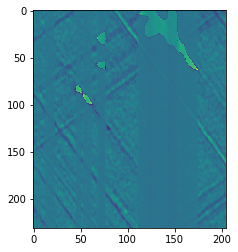

In [14]:
## plotting an example image
testing = scaled_phase1
%matplotlib inline
ax = plt.imshow((scaled_phase1[10]))
#ax.set_clim(-4.5,4.5)
#plt.savefig('D:/Layerwise/' + 'raw', format='pdf', dpi=300)

C:\Users\Josh_\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


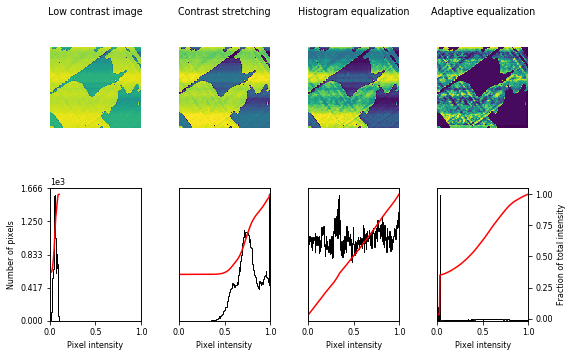

In [15]:
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    #image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.viridis)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = np.flipud(scaled_phase1[24].T)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [16]:
#function used to sharpen the contrast of the images
def contrast_sharpen (image):
    for i in range(len(image)):
        p2, p98 = np.percentile(image[i], (2, 98))
        image[i] = exposure.rescale_intensity(image[i], in_range=(p2, p98))
    return image


In [17]:
# Sharpening the contrast on all images in the data set
cs_amp1 = contrast_sharpen(scaled_amp1)
cs_amp2 = contrast_sharpen(scaled_amp2)
cs_height = contrast_sharpen(scaled_height)
cs_phase1 = contrast_sharpen(scaled_phase1)
cs_phase2 = contrast_sharpen(scaled_phase2)

In [18]:
# defining function to flip and transpose the array
def flip_trans (image):
    for i in range(len(image)):
        image[i] = np.flipud(image[i].T)
        #image[i] = image[i][:200,:]
    return image

In [19]:
# fliping the data and transposing it in order to match orientation to asylum analysis
amp1_fin = flip_trans(cs_amp1)
amp2_fin = flip_trans(cs_amp2)
height_fin = flip_trans(cs_height)
phase1_fin = flip_trans(cs_phase1)
phase2_fin = flip_trans(cs_phase2)

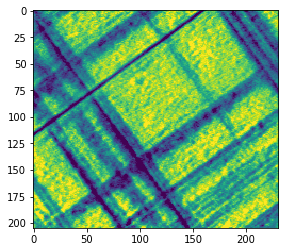

In [20]:
## plotting an example image
%matplotlib inline
ax = plt.imshow(amp2_fin[1])
#ax.set_clim(-4.5,4.5)
#plt.savefig('D:/Layerwise/' + 'raw', format='pdf', dpi=300)

In [61]:
np.save('prepull', amp2_fin[1])

In [21]:
im = amp2_fin[0]
im = img_as_ubyte(im)
for i in range(len(im[:,1]-1)):
    for k in range(len(im[1]-1)):
        if im[i,k] ==255:
            im[i,k] = im[i,k]-1

C:\Users\Josh_\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [27]:

def draw_lines(event,x,y,flags,param):
    global ix, iy, drawing
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x,y
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.line(im,(ix,iy),(x,y),(255),2)

In [28]:
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_lines)

while(1):
    cv2.imshow('image',im)
    k = cv2.waitKey(1) 
    if k == 27:
        break
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [29]:
cv2.imshow('image',im)
cv2.waitKey(0)
cv2.destroyAllWindows()

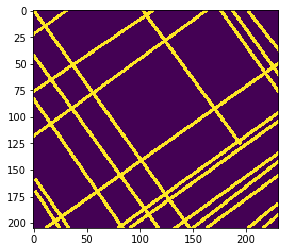

In [30]:
mask = im == 255

plt.imshow(mask)

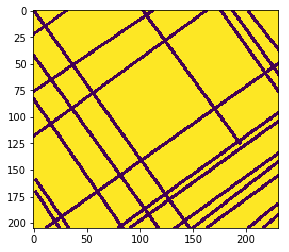

In [31]:
dist = np.logical_not(mask)
plt.imshow(dist)

In [32]:
distance_array = ndi.morphology.distance_transform_edt(dist)

In [34]:
np.save("dist_arr_doped",distance_array)

In [28]:
import pickle

with open("doped_dist.txt", "wb") as fp:   #Pickling
    pickle.dump(distance_array, fp)
 
with open("doped_dist.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

b.shape


205

In [29]:
b.shape

(205, 231)

In [ ]:
for n,image in enumerate(phase1_fin):
    plt.hist(image.reshape(-1))
    plt.savefig("D:/switching study/doped_hist/hist_doped" + str(n))
    plt.close()

In [15]:
## Extracting regions and region props for the images 6-28
im2 = phase1_fin
switch = [im2[i]>0.9 for i in range(len(im2))]
bilat = [mean_bilateral(switch[i].astype(np.uint16), disk(1)) for i in range(len(switch))]
bw = [closing(bilat[i], square(3)) for i in range(len(bilat))]
label_img = [label(bilat[i]) for i in range(len(bilat))]



In [19]:
import pickle

with open("doped_bilat.txt", "wb") as fp:   #Pickling
    pickle.dump(bilat, fp)
 
with open("doped_bilat.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

len(b)

28

In [16]:
# setting up the lists for features
regions = []
region6 = []
region7 = []
region8 = []
region9 = []
region10 = []
region11 = []
region12 = []
region13 = []
region14 = []
region15 = []
region16 = []
region17 = []
region18 = []
region19 = []
region20 = []
region21 = []
region22 = []
region23 = []
region24 = []
region25 = []
region26 = []
region27 = []

for region in regionprops (label_img[6]):
     # take regions with large enough areas
        if region.area >= 3.0 and region.centroid[0] <60 and region.centroid[1]<60:
            region6.append(region)
regions.append(region6)
for region in regionprops (label_img[7]):
     # take regions with large enough areas
        if region.area >= 3.0 and region.centroid[0] <60 and region.centroid[1]<60:
            region7.append(region)
regions.append(region7)
for region in regionprops (label_img[8]):
     # take regions with large enough areas
        if region.area >= 3.0 and region.centroid[0] <75 and region.centroid[1]<75:
            region8.append(region)
regions.append(region8)

## setting up conditions for the rest of the extraction

im2 = phase1_fin
switch = [im2[i]>0.2 for i in range(len(im2))]
bilat = [mean_bilateral(switch[i].astype(np.uint16), disk(1)) for i in range(len(switch))]
bw = [closing(bilat[i], square(3)) for i in range(len(bilat))]
label_img = [label(bilat[i]) for i in range(len(bilat))]

for region in regionprops (label_img[9]):
     # take regions with large enough areas
        if region.area >= 8.0 and 40<region.centroid[0]<70 and region.centroid[1]<150:
            region9.append(region)
regions.append(region9)
            
for region in regionprops (label_img[10]):
     # take regions with large enough areas
        if region.area >= 8.0 and (40<region.centroid[0]<100 or 120<region.centroid[0]<160) and 20<region.centroid[1]<110:
            region10.append(region)
regions.append(region10)

for region in regionprops (label_img[11]):
     # take regions with large enough areas
        if region.area >= 8.0 and (40<region.centroid[0]<100 or 120<region.centroid[0]<160) and region.centroid[1]<110:
            region11.append(region)
regions.append(region11)

for region in regionprops (label_img[12]):
     # take regions with large enough areas
        if region.area >= 8.0 and 40<region.centroid[0]<160:
            region12.append(region)
regions.append(region12)

for region in regionprops (label_img[13]):
     # take regions with large enough areas
        if region.area >= 8.0 and 40<region.centroid[0]<160:
            region13.append(region)
regions.append(region13)

for region in regionprops (label_img[14]):
     # take regions with large enough areas
        if region.area >= 8.0 and 40<region.centroid[0]:
            region14.append(region)
regions.append(region14)

for region in regionprops (label_img[15]):
     # take regions with large enough areas
        if region.area >= 8.0 and 10<region.centroid[0]:
            region15.append(region)
regions.append(region15)

for region in regionprops (label_img[16]):
     # take regions with large enough areas
        if region.area >= 8.0 and 10<region.centroid[0]:
            region16.append(region)
regions.append(region16)

for region in regionprops (label_img[17]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region17.append(region)
regions.append(region17)

for region in regionprops (label_img[18]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region18.append(region)                                   
regions.append(region18)

for region in regionprops (label_img[19]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region19.append(region)                                   
regions.append(region19)

for region in regionprops (label_img[20]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region20.append(region)                                   
regions.append(region20)

for region in regionprops (label_img[21]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region21.append(region)                                   
regions.append(region21)

for region in regionprops (label_img[22]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region22.append(region)                                   
regions.append(region22)

for region in regionprops (label_img[23]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region23.append(region)                                   
regions.append(region23)

for region in regionprops (label_img[24]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region24.append(region)                                   
regions.append(region24)

for region in regionprops (label_img[25]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region25.append(region)                                   
regions.append(region25)

for region in regionprops (label_img[26]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region26.append(region)                                   
regions.append(region26)

for region in regionprops (label_img[27]):
     # take regions with large enough areas
        if region.area >= 8.0:
            region27.append(region)                                   
regions.append(region27)



                                 
                                   

In [17]:
image_label_overlay = [label2rgb(label_img[i], bg_color =(0,0,0)) for i in range(len(label_img))]
image_label_overlay = [rgb2grey(image_label_overlay[i]) for i in range(len(label_img))]

In [37]:
len(phase1_fin)

28

In [65]:
for i in range(22):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    ax1.imshow(phase1_fin[i+6])
    
    ax2.imshow(image_label_overlay[i+6])
    
    for region in regions[i]:

            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                        fill=False, edgecolor='r', linewidth=2)
            ax2.add_patch(rect)
    ax3.imshow(bw[i+6])
    
    plt.tight_layout()
    plt.savefig("D:/switching study/doped_fin" + str(i+6), format="png", dpi=300)
    plt.close()

In [61]:
import pickle

with open("doped.txt", "wb") as fp:   #Pickling
    pickle.dump(regions, fp)
 
with open("doped.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

len(b)


22

In [48]:
## finding the number of nucleation events (number of regions)

nucleation = []
for image in regions:
    nucleation.append(len(image))

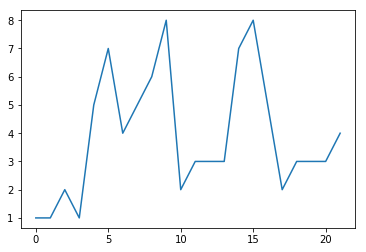

In [50]:
plt.plot(nucleation)

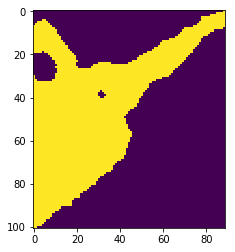

In [60]:
plt.imshow(region17[1].image)

In [ ]:
h = [regionprops(label_img[i]) for i in range(len(label_img))]

In [ ]:
center =np.empty((55,480,2),dtype=float)
for i in range(len(h)):
    for k in range(len(h[i])):
        center[i][k][0]=(h[i][k].centroid[0])
        center[i][k][1]=(h[i][k].centroid[1])

In [ ]:
round_center = np.around(center)
round_int = round_center.astype(int)

In [ ]:
distance = np.empty((55,480,1), dtype=float)
for i in range(len(h)):
    for k in range(len(h[i])):
        distance[i][k] = distance_array[round_int[i][k][0],round_int[i][k][1]]
        
rounded_distance = np.around(distance)

In [ ]:
a = [plt.hist(rounded_distance[i].reshape(-1),bins=50) for i in range(len(h))]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [ ]:
a[1][1]

In [ ]:
np.cumsum(np.diff(a[1][1]))

In [ ]:
for i in range(len(h)):
    y = np.cumsum(np.diff(a[i][1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(h)):
    for k in range(len(h[i])):
        ax.scatter(y,10*i,a[i][0])
ax.set_zlim(0,40)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    for k in range(len(h[i])):
        ax.bar(a[i][1][:50],a[i][0],zdir='y')

plt.show()

In [ ]:
h= regionprops(label_img)
center = [h[i].centroid for i in range(len(h))]
round_center = np.zeros((len(h),2))
for i in range(len(center)):
    for k in range(2):
        round_center[i][k] = round(center[i][k])

In [ ]:
distance = [distance_array[(int(round_center[i][0]),int(round_center[i][1]))] for i in range(len(round_center))]

In [ ]:
rounded_distance = [round(distance[i]) for i in range(len(distance))]
rounded_distance
fig, ax = plt.subplots(1,2, figsize=(10,15), sharex=False, sharey=False)
ax[0] = plt.hist(rounded_distance, bins= 20)
ax[1] = plt.hist(rounded_distance, bins= 30)

In [ ]:
dist = ndi.morphology.distance_transform_edt(markers)
